In [2]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt

In [3]:
reload_matches = False

In [4]:
if reload_matches: 
    url = 'https://api.vexdb.io/v1/get_matches'
    payload = {
        'season' : 'current',
        'scored' : 1,
    }
    r = requests.get(url, params=payload)

In [5]:
if reload_matches:
    response_json = json.loads(r.text)
    matches_raw = response_json['result']
    response_size = response_json['size']

In [6]:
if reload_matches:
    # Download all the matches!!! (Apologies to AURA :P )
    while response_size > 0:
        url = 'https://api.vexdb.io/v1/get_matches'
        payload = {
            'season' : 'current',
            'scored' : 1,
            'limit_start' : len(matches_raw)
        }
        r = requests.get(url, params=payload)
        response_json = json.loads(r.text)
        matches_raw.extend(response_json['result'])
        response_size = response_json['size']

        print(response_size)
        time.sleep(2)

In [7]:
def simplify_match(match_data):
    try:
        red_teams = [match_data['red1'], match_data['red2'], match_data['red3']]
        red_teams.remove(match_data['redsit'])
        red_score = match_data['redscore']

        blue_teams = [match_data['blue1'], match_data['blue2'], match_data['blue3']]
        blue_teams.remove(match_data['bluesit'])
        blue_score = match_data['bluescore']

        event = match_data['sku']
        vexu = 'VEXU' in event

        return {
            'red_teams' : red_teams,
            'red_score' : red_score,
            'blue_teams' : blue_teams,
            'blue_score' : blue_score,
            'event_sku' : event,
            'isVEXU' : vexu
        }
    except:
        return None

In [8]:
if reload_matches:
    simplified_matches = list(filter(lambda m: m is not None and not m['isVEXU'], map(simplify_match, matches_raw)))
    with open('simplified_match_data.json', 'w') as f:
        json.dump(simplified_matches, f)
else:
    with open('simplified_match_data.json') as f:
        simplified_matches = json.load(f)

In [9]:
vrc_matches = pd.DataFrame(simplified_matches)

In [10]:
reload_dates = True
if reload_dates:
    event_to_date_memo = {}
else:
    with open('date_memo.json') as f:
        event_to_date_memo = json.load(f)

In [11]:
def event_to_date(event_sku):
    if event_sku in event_to_date_memo:
        return event_to_date_memo[event_sku]
    
    time.sleep(1)
    url = 'https://api.vexdb.io/v1/get_events'
    payload = {
        'sku' : event_sku
    }
    r = requests.get(url, params=payload)
    result_json = json.loads(r.text)['result'][0]
    
    event_date = pd.to_datetime(result_json['end'])

    event_to_date_memo[event_sku] = event_date
    return event_date

In [12]:
event_to_date('RE-VRC-17-3803')
print(event_to_date_memo)

{'RE-VRC-17-3803': Timestamp('2018-04-28 23:59:59')}


In [30]:
vrc_matches['event_date'] = vrc_matches['event_sku'].apply(event_to_date)
if reload_dates:
    with open('date_memo.json', 'w') as f:
        json.dump(event_to_date_memo, f)

TypeError: Timestamp('2018-01-20 23:59:59') is not JSON serializable

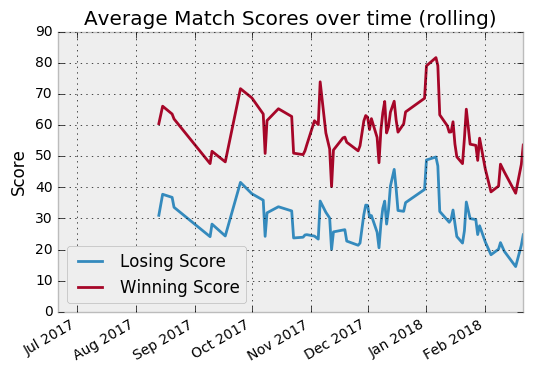

In [14]:
vrc_matches['Winning Score'] = vrc_matches[['red_score', 'blue_score']].max(axis=1)
vrc_matches['Losing Score'] = vrc_matches[['red_score', 'blue_score']].min(axis=1)
score_per_date = vrc_matches.groupby('event_date')[['Losing Score', 'Winning Score']].mean()
dev_score_per_date = vrc_matches.groupby('event_date')[['Losing Score', 'Winning Score']].std()

plt.style.use('bmh')
ax = score_per_date.rolling(3).mean().plot()

ax.set_title('Average Match Scores over time (rolling)')
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.set_ylim(0)

plt.show()

In [15]:
from collections import Counter
match_counter = Counter()
for match in simplified_matches:
    match_counter.update(match['red_teams'])
    match_counter.update(match['blue_teams'])

In [16]:
match_count_freq = Counter([x[1] for x in match_counter.items()])

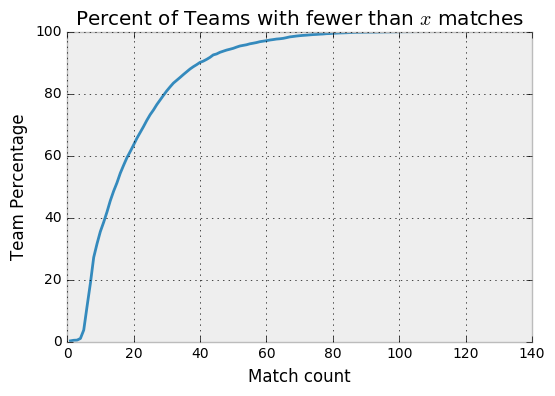

In [17]:
from itertools import accumulate
from operator import add

xs = [p[0] for p in match_count_freq.items()]
heights = [p[1] for p in match_count_freq.items()]
total_teams = sum(heights)
heights2 = [100*x/total_teams for x in accumulate(heights)]

plt.plot(xs, heights2)
plt.title('Percent of Teams with fewer than $x$ matches')
plt.xlabel('Match count')
plt.ylabel('Team Percentage')
plt.show()

In [18]:
match_counter['9605A']

70

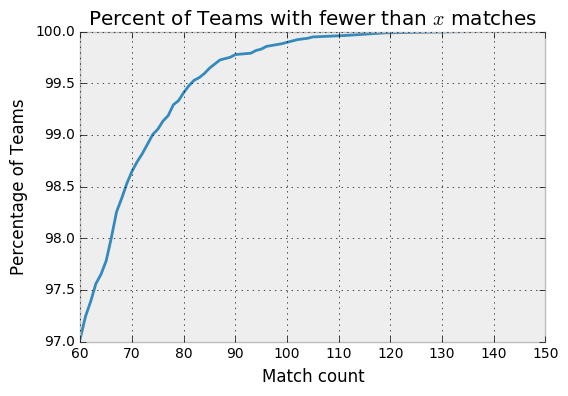

In [19]:
plt.plot(xs, heights2)
plt.title('Percent of Teams with fewer than $x$ matches')
plt.xlabel('Match count')
plt.ylabel('Percentage of Teams')
plt.xlim(60, 150)
plt.ylim(97, 100)
plt.show()

In [20]:
hardcore_teams = [x[0] for x in match_counter.items() if x[1] > 35]

In [21]:
test_hardcore = lambda l: all([match_counter[team] > 35 for team in l])
has_hardcore_team = vrc_matches['red_teams'].apply(test_hardcore) | vrc_matches['blue_teams'].apply(test_hardcore)

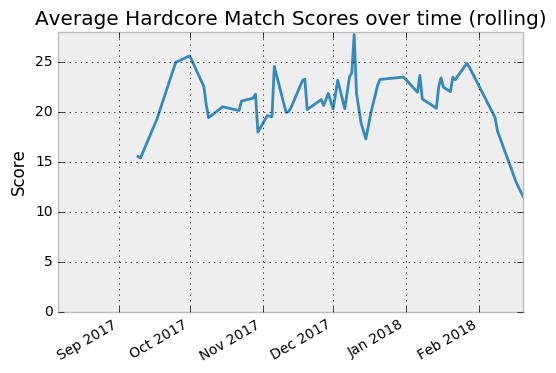

In [25]:
vrc_matches['spread'] = vrc_matches['Winning Score'] - vrc_matches['Losing Score']
score_per_date = vrc_matches[has_hardcore_team].groupby('event_date')['spread'].std()

plt.style.use('bmh')
ax = score_per_date.rolling(3).mean().plot()

ax.set_title('Average Hardcore Match Scores over time (rolling)')
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.set_ylim(0)

plt.show()

In [23]:
len(vrc_matches)

38037

In [24]:

plt.style.use('bmh')
ax = score_spread.sort_values().plot(use_index=False)

ax.set_title('Average Hardcore Match Scores over time (rolling)')
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.set_ylim(0)

plt.show()

NameError: name 'score_spread' is not defined

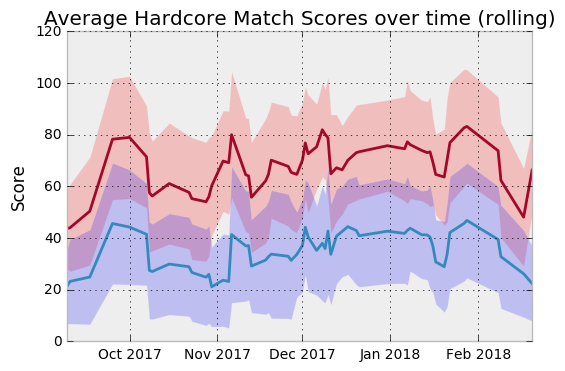

In [26]:
vrc_matches['Winning Score'] = vrc_matches[['red_score', 'blue_score']].max(axis=1)
vrc_matches['Losing Score'] = vrc_matches[['red_score', 'blue_score']].min(axis=1)
the_group = vrc_matches[has_hardcore_team].groupby('event_date')[['Losing Score', 'Winning Score']]
score_per_date = the_group.mean()
dev_score_per_date = the_group.std()

plt.style.use('bmh')

mean_scores = score_per_date.rolling(3).mean()
mean_dev = dev_score_per_date.rolling(3).mean()

# plot mean lines
plt.plot_date(mean_scores.index, mean_scores['Losing Score'], '-')
plt.plot_date(mean_scores.index, mean_scores['Winning Score'], '-')

# plot error bars
top_winning = mean_scores['Winning Score'] + mean_dev['Winning Score']
low_winning = mean_scores['Winning Score'] - mean_dev['Winning Score']
plt.fill_between(mean_dev.index, top_winning, low_winning,
                facecolor='red', alpha=0.2, interpolate=True)

top_losing = mean_scores['Losing Score'] + mean_dev['Losing Score']
low_losing = mean_scores['Losing Score'] - mean_dev['Losing Score']
plt.fill_between(mean_dev.index, top_losing, low_losing,
                facecolor='blue', alpha=0.2, interpolate=True)

ax = plt.gca()
ax.set_title('Average Hardcore Match Scores over time (rolling)')
ax.set_ylabel('Score')
ax.set_xlabel('')
ax.set_ylim(0)

plt.show()